In [2]:
import pandas as pd

In [160]:
def read_prepare(filepath, sheet_name):
    df = pd.read_excel(filepath,sheet_name=sheet_name)
    print("length before cleaning:", len(df))
    print("NaNs before cleaning: ", df.isna().sum().sum())
    df.columns = [x.strip().lower().replace(" ", "_").replace("-", "_") for x in df.columns]
    df["dato____arbeidsdagen"] = pd.to_datetime(df["dato____arbeidsdagen"], errors='coerce')
    df.dropna(axis = 1, inplace=True, how="all")
    df.sort_values(by="dato____arbeidsdagen", inplace=True)
    print("length after cleaning:", len(df))
    print("NaNs after cleaning: ", df.isna().sum().sum())
    return df

In [267]:
filepath = '/Users/sigvardbratlie/Library/CloudStorage/GoogleDrive-sigvard.bratlie@gmail.com/Min disk/GEN-F/00_IA/00 - Fra Fredrik 2/2022-23/Time registering - Gen-F 22_23 (Svar).xlsx'
df22 = read_prepare(filepath,"Svarene fra timereg")

filepath23 = '/Users/sigvardbratlie/Library/CloudStorage/GoogleDrive-sigvard.bratlie@gmail.com/Min disk/GEN-F/00_IA/00 - Fra Fredrik 2/2022-23/Timeregistering  2023 - Input - halvår 2.xlsx'
df23 = read_prepare(filepath23,"Svarene fra timereg")

length before cleaning: 1169
NaNs before cleaning:  5465
length after cleaning: 1169
NaNs after cleaning:  3127
length before cleaning: 1206
NaNs before cleaning:  3088
length after cleaning: 1206
NaNs after cleaning:  3097


/Users/sigvardbratlie/Documents/Projects/genf/.venv/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:223: UserWarning: Cell F775 is marked as a date but the serial value 6619409.0 is outside the limits for dates. The cell will be treated as an error.
  warn(msg)


In [268]:
df23.loc[(df23["dato____arbeidsdagen"].dt.year != 2023) | (df23["dato____arbeidsdagen"].dt.month > 7) ,"dato____arbeidsdagen"] = pd.NaT
df23["dato____arbeidsdagen"] = df23["dato____arbeidsdagen"].fillna(df23["tidsmerke"])

In [269]:
df = pd.concat([df22, df23], ignore_index=True)

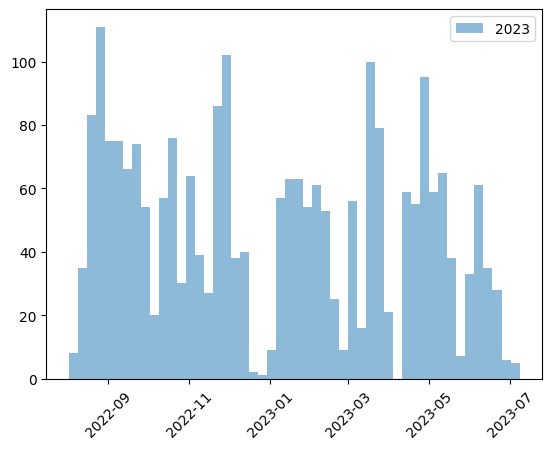

In [270]:
import matplotlib.pyplot as plt

plt.hist(df["dato____arbeidsdagen"], bins=50, alpha=0.5, label='2023')
plt.legend()
plt.xticks(rotation=45)
plt.show() 

In [271]:

def transform_old_data(df):
    rename_map = {"ditt_navn": "navn",
                "dato____arbeidsdagen": "dato",
                "antall_timer": "timer",
                "mentor_eller_u16" : "rolle",
                "type_jobb" : "prosjekt"
                }
    df.rename(columns=rename_map, inplace=True)
    df = df[["tidsmerke", "dato","rolle","timer","navn","prosjekt","sted"]]

    #df.loc[(df["sted"].isin(["Gjersjøen","Sjeisenåsen", "Glenne"])) & (df["prosjekt"] != "Flasker"),"prosjekt"] = "Jobb hvit"
    df.loc[(df["sted"].isin(["Glenne"])),"gruppe"] = "Glenne Gård"
    df.loc[(df["sted"].isin(["Gjersjøen","Sjeisenåsen"])),"gruppe"] = "BCC OF"

    map_prosjekt = {"Vedpakking" : ["Veddugnad","Ved dudgnad", "Vedproduksjon","Ved","Ved jobb","Ved dugnad","Veddugnad","Ved dugnad"],
                    "Mersalg" : ['"Mersalg'],
                    "Utomhus" : ["Utomhus", "Kvistdugnad","Kvistjobb","Kviste dugnad","Stokkdugnad"],
                    "Vask" : ["Vasking", "Vask"],
                    "Matlaging" : ["Matlaging (ikke til kiosksalg)","Matlaging"],
                    "Kiosk" : ["Kiosk"],
                    "Jobb hvit" : ["Jobb hvit","Jobbhvit"],
                    }
    df["prosjekt"] = df["prosjekt"].replace({v:k for k, lst in map_prosjekt.items() for v in lst})


    map_gruppe = {"BCC OF" : ["Vasking","Utomhus","Rigg","Matlaging","Mersalg","Golfballplukking" ],
    "Gjersjøen" : ["Kiosk"], 
    "BUK" : ["Flasker"],
    "Glenne Gård" : ["Veddugnad",],
    "Annet" : ["Jobb hvit"],
    }
    for gruppe, prosjekter in map_gruppe.items():
        df.loc[df["prosjekt"].isin(prosjekter), "gruppe"] = gruppe

    df["gruppe"] = df["gruppe"].fillna("Annet")

    rolle_map = {"genf" : "U16",
                 "mentor" : "Mentor",
                 "mentor" : "O16",}
    df["rolle"] = df["rolle"].replace({v:k for k, v in rolle_map.items()}).str.lower()
    df['dato'] = df['dato'].dt.tz_localize('UTC')
    df["tidsmerke"] = df["tidsmerke"].dt.tz_localize('UTC')
    return df

In [272]:
df = transform_old_data(df)

/var/folders/qv/k9q4x60x4wn1fy68fsy_wtl00000gn/T/ipykernel_40385/3930891148.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(df["sted"].isin(["Glenne"])),"gruppe"] = "Glenne Gård"
/var/folders/qv/k9q4x60x4wn1fy68fsy_wtl00000gn/T/ipykernel_40385/3930891148.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prosjekt"] = df["prosjekt"].replace({v:k for k, lst in map_prosjekt.items() for v in lst})
/var/folders/qv/k9q4x60x4wn1fy68fsy_wtl00000gn/T/ipykernel_40385/3930891148.py:35: SettingWithCo

In [273]:
from google.cloud import bigquery
client = bigquery.Client()

job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("dato", "TIMESTAMP"),
        bigquery.SchemaField("tidsmerke", "TIMESTAMP"),
    ],
    write_disposition="WRITE_TRUNCATE",
)

client.load_table_from_dataframe(
    df, 
    "genf.timer_22_23",
    job_config=job_config
).result()

LoadJob<project=genf-446213, location=EU, id=32767ef4-fe37-4cf4-8551-13b51eb5cdde>

In [ ]:

mal = client.query("SELECT * FROM genf.sesong_25_26").result().to_dataframe()

E0000 00:00:1764859500.595553 7266822 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [262]:
file = '/Users/sigvardbratlie/Library/CloudStorage/GoogleDrive-sigvard.bratlie@gmail.com/Min disk/GEN-F/00_IA/00 - Fra Fredrik 2/2023-24/Timene til Lønn 23_24.xlsx'
sheet_name = "Skjemasvar 1"
df = read_prepare(file, sheet_name)
df.loc[(df["dato____arbeidsdagen"] < pd.Timestamp("2023-08-01")) ,"dato____arbeidsdagen"] = pd.NaT
df["dato____arbeidsdagen"] = df["dato____arbeidsdagen"].fillna(df["tidsmerke"])

length before cleaning: 2441
NaNs before cleaning:  10295
length after cleaning: 2441
NaNs after cleaning:  10295


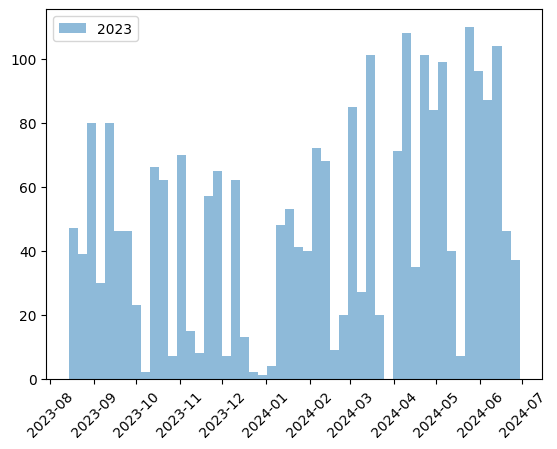

In [263]:
import matplotlib.pyplot as plt

plt.hist(df["dato____arbeidsdagen"], bins=50, alpha=0.5, label='2023')
plt.legend()
plt.xticks(rotation=45)
plt.show() 

In [264]:
rename_map = {"ditt_navn": "navn",
            "dato____arbeidsdagen": "dato",
            "timer_til_utbetaling": "timer",
            "mentor_eller_u16" : "rolle",
            "type_jobb" : "prosjekt"
            }
df.rename(columns=rename_map, inplace=True)
df = df[["tidsmerke", "dato","rolle","timer","navn","prosjekt","sted"]]

#df.loc[(df["sted"].isin(["Gjersjøen","Sjeisenåsen", "Glenne"])) & (df["prosjekt"] != "Flasker"),"prosjekt"] = "Jobb hvit"
df.loc[(df["sted"].isin(["Glenne"])),"gruppe"] = "Glenne Gård"
df.loc[(df["sted"].isin(["Gjersjøen","Sjeisenåsen"])),"gruppe"] = "BCC OF"

map_prosjekt = {"Vedpakking" : ["Veddugnad","Ved dudgnad", "Vedproduksjon","Ved","Ved jobb","Ved dugnad","Veddugnad","Ved dugnad"],
                "Mersalg" : ['"Mersalg'],
                "Utomhus" : ["Utomhus", "Kvistdugnad","Kvistjobb","Kviste dugnad","Stokkdugnad"],
                "Vask" : ["Vasking", "Vask"],
                "Matlaging" : ["Matlaging (ikke til kiosksalg)","Matlaging"],
                "Kiosk" : ["Kiosk"],
                "Jobb hvit" : ["Jobb hvit","Jobbhvit"],
                }
df["prosjekt"] = df["prosjekt"].replace({v:k for k, lst in map_prosjekt.items() for v in lst})


map_gruppe = {"BCC OF" : ["Vasking","Utomhus","Rigg","Matlaging","Mersalg","Golfballplukking" ],
"Gjersjøen" : ["Kiosk"], 
"BUK" : ["Flasker"],
"Glenne Gård" : ["Veddugnad",],
"Annet" : ["Jobb hvit"],
}
for gruppe, prosjekter in map_gruppe.items():
    df.loc[df["prosjekt"].isin(prosjekter), "gruppe"] = gruppe

df["gruppe"] = df["gruppe"].fillna("Annet")

rolle_map = {"genf" : "U16",
                 "mentor" : "Mentor",
                 "mentor" : "O16",}
df["rolle"] = df["rolle"].replace({v:k for k, v in rolle_map.items()}).str.lower()
df['dato'] = df['dato'].dt.tz_localize('UTC')
df["tidsmerke"] = df["tidsmerke"].dt.tz_localize('UTC')
df.head()

,tidsmerke,dato,rolle,timer,navn,prosjekt,sted,gruppe
179,2023-09-06 08:57:28.783000+00:00,2023-09-06 08:57:28.783000+00:00,mentor,7.833333,Susanne Høines,Kiosk,Gjersjøen,Gjersjøen
192,2023-09-09 13:55:35.562000+00:00,2023-09-09 13:55:35.562000+00:00,mentor,4.500000,Kim Kristiansen,Flasker,Sjeisenåsen,BUK
191,2023-09-08 12:05:53.149000+00:00,2023-09-08 12:05:53.149000+00:00,mentor,3.000000,Susanne Høines,Kiosk,Innkjøp Storcash/ lever varene på Gjersjøen,Gjersjøen
0,2023-08-14 21:44:26.422000+00:00,2023-08-14 00:00:00+00:00,genf,2.000000,Elise Hud,Vask,Gjersjøen,BCC OF
1,2023-08-14 21:44:26.422000+00:00,2023-08-14 00:00:00+00:00,mentor,2.000000,Sandra Kristiansen,Vask,Gjersjøen,BCC OF


In [266]:
job_config = bigquery.LoadJobConfig(
    schema=[
        bigquery.SchemaField("dato", "TIMESTAMP"),
        bigquery.SchemaField("tidsmerke", "TIMESTAMP"),
    ],
    write_disposition="WRITE_TRUNCATE",
)

client.load_table_from_dataframe(
    df, 
    "genf.timer_23_24",
    job_config=job_config
).result()

LoadJob<project=genf-446213, location=EU, id=31df6816-e3d3-4793-93d8-29c0216b3bbe>

In [232]:
df.tail()

,dato,navn,rolle,gruppe,prosjekt,timer,kostnad,alder,kommentar,antall_enheter,kontonr,epost
12879,2025-11-20 00:00:00+00:00,Leah Marie,genf,Glenne Gård,Vedpakking,4.500000,750.0,13.0,(50 antall) Jeg jobba 30 august men fikk ikke ...,50,11004969407,leahekholt@icloud.com
12880,2025-10-11 00:00:00+00:00,Aron,genf,Glenne Gård,Vedpakking,4.500000,450.0,13.0,(30 antall) Mathias.H,30,61851101003,aronmtwilley@gmail.com
12881,2025-11-15 00:00:00+00:00,Charlie Irving,genf,Glenne Gård,Vedpakking,4.000000,525.0,13.0,(35 antall) Glenne,35,62421053745,charlie.irv@icloud.com
12882,2025-11-01 00:00:00+00:00,Phillip Gangsø,genf,Glenne Gård,Vedpakking,0.016667,450.0,13.0,(30 antall) Alex erz glenne,30,12260121543,phillip.gangso@gmail.com
12883,2025-11-22 00:00:00+00:00,Alexander,genf,Glenne Gård,Vedpakking,4.000000,645.0,13.0,(43 antall) mentor alex og sigvard,43,36264854843,alexnilsen2012@gmail.com


## MERGE

E0000 00:00:1764864635.728747 7266822 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1764864637.546373 7266822 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1764864639.346317 7266822 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1764864641.105116 7266822 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [275]:
df.head()

,dato,navn,rolle,gruppe,prosjekt,timer,kostnad,alder,kommentar,antall_enheter,kontonr,epost
0,2022-08-13 00:00:00+00:00,Isaac vedvik,genf,Annet,Tømmer og kvister,3.0,300.0,<NA>,NaN,<NA>,<NA>,NaN
1,2022-08-13 00:00:00+00:00,Magnus Fuglset,genf,Annet,Vasking/Lørdags dugnad,4.0,400.0,<NA>,NaN,<NA>,<NA>,NaN
2,2022-08-20 00:00:00+00:00,Savannah Schmidt,genf,BCC OF,Fjerne ugress,5.0,500.0,<NA>,NaN,<NA>,<NA>,NaN
3,2022-08-20 00:00:00+00:00,Ariana Havekes,genf,Annet,Maling,4.0,400.0,<NA>,NaN,<NA>,<NA>,NaN
4,2022-08-27 00:00:00+00:00,Jonathan Schmidt,genf,Annet,Nordli ved dugnad,2.5,250.0,<NA>,NaN,<NA>,<NA>,NaN


In [ ]:
# Sjekk hvilke kolonner som har problem
print(df['dato'].dtype)
# Eller: Legg til UTC på alle



object


In [281]:
df["dato"].min(), df["dato"].max()

(Timestamp('2022-08-02 00:00:00+0000', tz='UTC'),
 Timestamp('2025-11-29 00:00:00+0000', tz='UTC'))